# Effectuez une prédiction de revenus

## Présentation

#### Vous êtes employé dans une banque, présente dans de nombreux pays à travers le monde. Celle-ci souhaite cibler de nouveaux clients potentiels, plus particulièrement les jeunes en âge d'ouvrir leur tout premier compte bancaire.
#### Cependant, elle souhaite cibler les prospects les plus susceptibles d'avoir, plus tard dans leur vie, de hauts revenus.
#### L'équipe dans laquelle vous travaillez a donc reçu pour mission de **créer un modèle permettant de déterminer le revenu potentiel d'une personne**.
#### Information à notre disposition :
- uniquement le revenu des parents, car nous allons cibler les enfants de nos clients actuels, ainsi que le pays où ils habitent
#### Condition : 
- ce modèle doit être valable pour la plupart des pays du monde
#### Vous proposez une régression linéaire avec 3 variables :
- le revenu des parents ;
- le revenu moyen du pays dans lequel habite le prospect ;
- l'indice de Gini calculé sur les revenus des habitants du pays en question.

#### Ce projet ne traite que de la construction et de l'interprétation du modèle. Vous n'irez pas jusqu'à la phase de prédiction.

## Sommaire
- [importation des librairies](#librairies)
- [importation et lecture des données](#donnee_revenus)
- [description du dataframe distribution revenus](#descript_donnee_revenus)
- [Mission 1](#mission_1)
    - [année(s) des données utilisées](#annee_donnee_revenus)
        - [création d'un dataframe avec code alpha 3 du pays et son nom ("df_dist_revenus_code)](#crea_code_revenus)
    - [nombre de pays présents pour l'analyse](#nb_pays_analyse)
        - [recherche du pays au centile manquant ...](#recherche_centile)
        - [Implémentation du quantile manquant par régression linéaire](#reg41)
        - [création d'un dataframe avec nombre d'habitants du pays ("df_revenus_pop")](#df_revenus_pop)
    - [pourcentage de population couverte par l'analyse (en termes de pourcentage de la population mondiale)](#nb_hab_analyse)
    - [Les données de la World Income Distribution présentent pour chaque pays les quantiles de la distribution des revenus de leur population respective](#mission_1_questions)
- [export en csv des différents dataframes nettoyés](#export_df_csv)
- [juste pour voir...](#juste_voir)
    - implémentation du centile 41 : retrouver une valeur sur un graphique (ici regplot)


Démarche :

- ajout de code iso 3 pour avoir le nom des pays
- implémentation des GPP PPP manquants du Kosovo et de Gaza
- ajout du nombre d'habitants de Taïwan 
- implémentation du quantile manquant

### Importation des librairies <a class="anchor" id="librairies"></a>

In [1]:
# Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from sklearn.impute import SimpleImputer

# librairies pour les tests
from scipy.stats import ks_2samp
import scipy.stats as st
from scipy.stats import levene

#  librairies pour le dendrogramme, Kmeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage,  fcluster, centroid
from scipy.spatial.distance import pdist
from sklearn import decomposition
from yellowbrick.cluster import KElbowVisualizer

# librairies pour l'ACP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import LineCollection

In [2]:
ENCODAGE = 'UTF-8'

In [3]:
sns.set(style="darkgrid")

### Importation et lecture des données (https://data.worldbank.org) <a class="anchor" id="donnee_revenus"></a>

#### Données extraites de World Income Distribution datée de 2008 
#### Cette base de données est composée principalement d'études réalisées au niveau national pour bon nombre de pays, et contient les distributions de revenus des populations concernées.
#### PPP : purchasing power parities ( = parités de pouvoir d'achat (PPA)) : méthode utilisée en économie pour établir une comparaison, entre pays, du pouvoir d'achat des devises nationales, ce qu’une simple utilisation des taux de change ne permet pas de faire. 
#### GDP PPP : Gross Domestic Product based on Purchasing Power : PIB basé sur le pouvoir d'achat
#### https://www.persee.fr/doc/receo_0338-0599_1996_num_27_4_2825

In [4]:
df_distrib_revenus = pd.read_csv('data-projet7.csv', decimal=",").copy()

In [5]:
df_distrib_revenus.head(5)

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0
3,ALB,2008,4,100,1086.90780,7297.0
4,ALB,2008,5,100,1132.69970,7297.0


#### Visualisation des variables

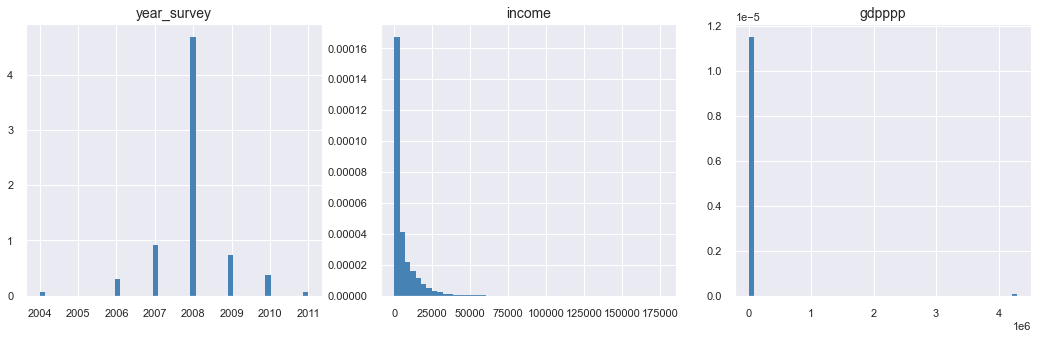

In [6]:
var_hist = ['year_survey', 'income', 'gdpppp']
fig = plt.figure(figsize=(18, 5))
i=0
for var in var_hist:
    ax = fig.add_subplot(1,3,(i+1))    
    plt.hist(df_distrib_revenus[var], bins=50, color='steelblue', density=True, edgecolor='none') 
#     sns.histplot(x=var,  data=df_distrib_revenus)
    ax.set_title(var, fontsize=14)
    i+=1
plt.show()


Remarque : les valeurs sont très différentes. Il faudra les standariser afin d'éviter qu'une variable prenne "supplante" l'autre.

### Description du dataset distribution revenus <a class="anchor" id="descript_donnee_revenus"></a>

In [7]:
df_distrib_revenus.shape

(11599, 6)

In [8]:
df_distrib_revenus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11599 entries, 0 to 11598
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11599 non-null  object 
 1   year_survey   11599 non-null  int64  
 2   quantile      11599 non-null  int64  
 3   nb_quantiles  11599 non-null  int64  
 4   income        11599 non-null  float64
 5   gdpppp        11399 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 543.8+ KB


In [11]:
df_distrib_revenus.describe(include='all', datetime_is_numeric=True)

,country,year_survey,quantile,nb_quantiles,income,gdpppp
count,11599,11599.000000,11599.000000,11599.0,11599.000000,1.139900e+04
unique,116,NaN,NaN,NaN,NaN,NaN
top,MNE,NaN,NaN,NaN,NaN,NaN
freq,100,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.982757,50.500819,100.0,6069.224260,5.022128e+04
std,NaN,0.909633,28.868424,0.0,9414.185972,4.000688e+05
min,NaN,2004.000000,1.000000,100.0,16.719418,3.031931e+02
25%,NaN,2008.000000,25.500000,100.0,900.685515,2.576000e+03
50%,NaN,2008.000000,51.000000,100.0,2403.244900,7.560000e+03
75%,NaN,2008.000000,75.500000,100.0,7515.420900,1.877300e+04


In [12]:
df_distrib_revenus.head(2)

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0


In [13]:
# Valeurs null => 200 valeurs null
df_distrib_revenus.isnull().sum(axis=0)

country           0
year_survey       0
quantile          0
nb_quantiles      0
income            0
gdpppp          200
dtype: int64

#### Remarque : 200 valeurs de gdpppp sont manquantes 

In [14]:
df_distrib_revenus_null = df_distrib_revenus[df_distrib_revenus['gdpppp'].isnull()]
df_distrib_revenus_null.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
5800,XKX,2008,1,100,437.89370,NaN
5801,XKX,2008,2,100,508.17133,NaN
5802,XKX,2008,3,100,591.82820,NaN
5803,XKX,2008,4,100,668.00000,NaN
5804,XKX,2008,5,100,730.40220,NaN


In [15]:
df_distrib_revenus_null.shape

(200, 6)

In [16]:
df_distrib_revenus_null.country.nunique()

2

In [17]:
df_distrib_revenus_null.country.unique()

array(['XKX', 'PSE'], dtype=object)

#### Remarque : **200 valeurs null pour la variable "gdpppp"** concernant **2** pays : 'XKX' et 'PSE'

In [18]:
# Valeurs dupliquées => pas de valeurs dupliquées
df_distrib_revenus.duplicated().sum(axis=0)

0

In [19]:
# Liste des pays par ordre alphabétique de code
df_distrib_revenus.country.sort_values(ascending=True).unique()

array(['ALB', 'ARG', 'ARM', 'AUT', 'AZE', 'BEL', 'BFA', 'BGD', 'BGR',
       'BIH', 'BLR', 'BOL', 'BRA', 'BTN', 'CAF', 'CAN', 'CHL', 'CHN',
       'CIV', 'CMR', 'COD', 'COL', 'CRI', 'CYP', 'CZE', 'DEU', 'DNK',
       'DOM', 'ECU', 'EGY', 'ESP', 'EST', 'FIN', 'FJI', 'FRA', 'GBR',
       'GEO', 'GHA', 'GIN', 'GRC', 'GTM', 'HND', 'HRV', 'HUN', 'IDN',
       'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JOR', 'JPN',
       'KAZ', 'KEN', 'KGZ', 'KHM', 'KOR', 'LAO', 'LBR', 'LKA', 'LTU',
       'LUX', 'LVA', 'MAR', 'MDA', 'MDG', 'MEX', 'MKD', 'MLI', 'MNE',
       'MNG', 'MOZ', 'MRT', 'MWI', 'MYS', 'NER', 'NGA', 'NIC', 'NLD',
       'NOR', 'NPL', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRT', 'PRY',
       'PSE', 'ROU', 'RUS', 'SDN', 'SLV', 'SRB', 'SVK', 'SVN', 'SWE',
       'SWZ', 'SYR', 'THA', 'TJK', 'TLS', 'TUR', 'TWN', 'TZA', 'UGA',
       'UKR', 'URY', 'USA', 'VEN', 'VNM', 'XKX', 'YEM', 'ZAF'],
      dtype=object)

In [20]:
df_distrib_revenus[df_distrib_revenus['country'] == 'AZE']

,country,year_survey,quantile,nb_quantiles,income,gdpppp
400,AZE,2008,1,100,397.53983,8101.0
401,AZE,2008,2,100,597.77320,8101.0
402,AZE,2008,3,100,705.47003,8101.0
403,AZE,2008,4,100,785.52610,8101.0
404,AZE,2008,5,100,841.75244,8101.0
...,...,...,...,...,...,...
495,AZE,2008,96,100,5283.54700,8101.0
496,AZE,2008,97,100,5802.63800,8101.0
497,AZE,2008,98,100,6366.05900,8101.0
498,AZE,2008,99,100,7459.71140,8101.0


In [21]:
df_distrib_revenus[df_distrib_revenus['country']=='ZAF']

,country,year_survey,quantile,nb_quantiles,income,gdpppp
11399,ZAF,2008,1,100,60.490383,9602.0
11400,ZAF,2008,2,100,138.341550,9602.0
11401,ZAF,2008,3,100,192.294500,9602.0
11402,ZAF,2008,4,100,236.994000,9602.0
11403,ZAF,2008,5,100,279.367580,9602.0
...,...,...,...,...,...,...
11494,ZAF,2008,96,100,24553.568000,9602.0
11495,ZAF,2008,97,100,28858.031000,9602.0
11496,ZAF,2008,98,100,35750.290000,9602.0
11497,ZAF,2008,99,100,46297.316000,9602.0


### Mission 1 <a class="anchor" id="mission_1"></a>
#### - Année(s) des données utilisées 
#### - Nombre de pays présents 
#### - population couverte par l'analyse (en termes de pourcentage de la population mondiale)

### Année(s) des données utilisées <a class="anchor" id="annee_donnee_revenus"></a>

In [22]:
df_distrib_revenus.year_survey.sort_values( ascending = True).unique()

array([2004, 2006, 2007, 2008, 2009, 2010, 2011], dtype=int64)

#### Remarque : les données couvrent les années de 2004 à 2011 inclus

#### Visualisation du nombre de pays analysés pour chaque année

In [23]:
df_distr_pays = df_distrib_revenus.groupby(['year_survey'])['country'].nunique().reset_index(name='nbre_pays')
df_distr_pays

,year_survey,nbre_pays
0,2004,1
1,2006,5
2,2007,15
3,2008,76
4,2009,12
5,2010,6
6,2011,1


<Figure size 720x720 with 0 Axes>

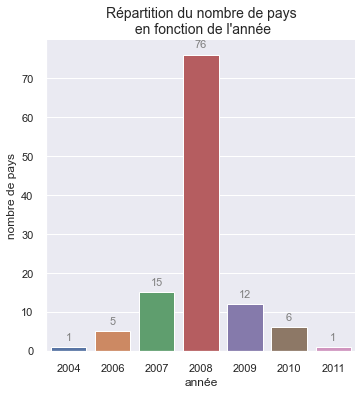

In [24]:
# distribustion du nombre de pays en fonction de la date
plt.figure(figsize=(10,10))
ax = sns.catplot(x='year_survey', y='nbre_pays', data=df_distr_pays, kind="bar")
for axe in ax.axes.ravel():
    for p in axe.patches:
                 axe.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11, color='grey', rotation=0, xytext=(0, 10),
                     textcoords='offset points')
plt.title('Répartition du nombre de pays\n en fonction de l\'année', size= 14)
plt.xlabel('année', size= 12)
plt.ylabel('nombre de pays', size= 12)
plt.savefig("Répartition du nombre de pays en fonction de l\'année.jpg")
# plt.show()

Autre visualisation de la distribution des années

<AxesSubplot:xlabel='year_survey', ylabel='Count'>

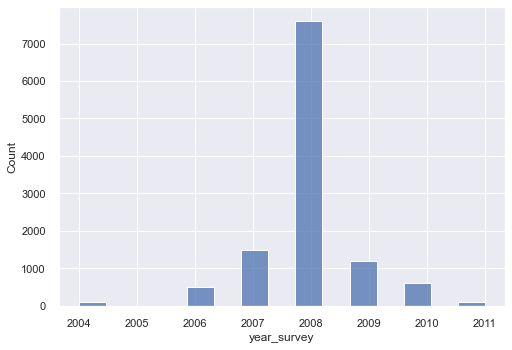

In [25]:
sns.histplot(x='year_survey', data=df_distrib_revenus)

#### Remarque : forte proportion pour 2008

### Renommage des colonnes

In [26]:
df_distrib_revenus_bis = df_distrib_revenus.rename(columns = {'country' : 'country_code', 'year_survey' : 'year'})

In [27]:
df_distrib_revenus_bis.head(2)

,country_code,year,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0


In [28]:
# Liste des codes alpha 3
ff = df_distrib_revenus_bis.country_code.sort_values(ascending=True).unique()
ff

array(['ALB', 'ARG', 'ARM', 'AUT', 'AZE', 'BEL', 'BFA', 'BGD', 'BGR',
       'BIH', 'BLR', 'BOL', 'BRA', 'BTN', 'CAF', 'CAN', 'CHL', 'CHN',
       'CIV', 'CMR', 'COD', 'COL', 'CRI', 'CYP', 'CZE', 'DEU', 'DNK',
       'DOM', 'ECU', 'EGY', 'ESP', 'EST', 'FIN', 'FJI', 'FRA', 'GBR',
       'GEO', 'GHA', 'GIN', 'GRC', 'GTM', 'HND', 'HRV', 'HUN', 'IDN',
       'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JOR', 'JPN',
       'KAZ', 'KEN', 'KGZ', 'KHM', 'KOR', 'LAO', 'LBR', 'LKA', 'LTU',
       'LUX', 'LVA', 'MAR', 'MDA', 'MDG', 'MEX', 'MKD', 'MLI', 'MNE',
       'MNG', 'MOZ', 'MRT', 'MWI', 'MYS', 'NER', 'NGA', 'NIC', 'NLD',
       'NOR', 'NPL', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRT', 'PRY',
       'PSE', 'ROU', 'RUS', 'SDN', 'SLV', 'SRB', 'SVK', 'SVN', 'SWE',
       'SWZ', 'SYR', 'THA', 'TJK', 'TLS', 'TUR', 'TWN', 'TZA', 'UGA',
       'UKR', 'URY', 'USA', 'VEN', 'VNM', 'XKX', 'YEM', 'ZAF'],
      dtype=object)

### Création d'un dataframe avec code alpha 3 du pays et son nom ("df_dist_revenus_code)  
#### (https://stefangabos.github.io/world_countries/#top)
<a class="anchor" id="crea_code_revenus"></a>
### Importation et lecture des codes pays (code ISO 3166-1) (https://satvasolutions.com/)

In [29]:
# Importation du dataframe comprenant les codes ISO 3166-1)
df_pays_code = pd.read_csv('code_pays.csv',usecols=[0,4])

In [30]:
df_pays_code.shape

(266, 2)

In [31]:
df_pays_code.head()

,Country Code,TableName
0,ABW,Aruba
1,AFE,Africa Eastern and Southern
2,AFG,Afghanistan
3,AFW,Africa Western and Central
4,AGO,Angola


In [32]:
df_pays_code.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country Code  266 non-null    object
 1   TableName     266 non-null    object
dtypes: object(2)
memory usage: 4.3+ KB


In [33]:
# valeur null => aucune valeur nulle
df_pays_code.isnull().sum(axis=0)

Country Code    0
TableName       0
dtype: int64

In [34]:
#  valeur dupliquée => aucune valeur dupliquée
df_pays_code.duplicated().sum(axis=0)

0

### Renommage des colonnes du dataframe comprenant les codes

In [35]:
# renommage des colonnes de "df_pays_code" en vue d'une prochaine fusion
df_pays_code_bis = df_pays_code.rename(columns ={'Country Code': 'country_code', 'TableName': 'country' })

In [36]:
df_pays_code_bis.head(2)

,country_code,country
0,ABW,Aruba
1,AFE,Africa Eastern and Southern


In [37]:
# Liste des codes alpha 3
ee = df_pays_code_bis.country_code.sort_values().unique()
ee

array(['ABW', 'AFE', 'AFG', 'AFW', 'AGO', 'ALB', 'AND', 'ARB', 'ARE',
       'ARG', 'ARM', 'ASM', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL',
       'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ',
       'BMU', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN',
       'CEB', 'CHE', 'CHI', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG',
       'COL', 'COM', 'CPV', 'CRI', 'CSS', 'CUB', 'CUW', 'CYM', 'CYP',
       'CZE', 'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'EAP', 'EAR',
       'EAS', 'ECA', 'ECS', 'ECU', 'EGY', 'EMU', 'ERI', 'ESP', 'EST',
       'ETH', 'EUU', 'FCS', 'FIN', 'FJI', 'FRA', 'FRO', 'FSM', 'GAB',
       'GBR', 'GEO', 'GHA', 'GIB', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC',
       'GRD', 'GRL', 'GTM', 'GUM', 'GUY', 'HIC', 'HKG', 'HND', 'HPC',
       'HRV', 'HTI', 'HUN', 'IBD', 'IBT', 'IDA', 'IDB', 'IDN', 'IDX',
       'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM',
       'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR',
       'KWT', 'LAC',

In [38]:
# df_distrib_revenus_bis
ff

array(['ALB', 'ARG', 'ARM', 'AUT', 'AZE', 'BEL', 'BFA', 'BGD', 'BGR',
       'BIH', 'BLR', 'BOL', 'BRA', 'BTN', 'CAF', 'CAN', 'CHL', 'CHN',
       'CIV', 'CMR', 'COD', 'COL', 'CRI', 'CYP', 'CZE', 'DEU', 'DNK',
       'DOM', 'ECU', 'EGY', 'ESP', 'EST', 'FIN', 'FJI', 'FRA', 'GBR',
       'GEO', 'GHA', 'GIN', 'GRC', 'GTM', 'HND', 'HRV', 'HUN', 'IDN',
       'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JOR', 'JPN',
       'KAZ', 'KEN', 'KGZ', 'KHM', 'KOR', 'LAO', 'LBR', 'LKA', 'LTU',
       'LUX', 'LVA', 'MAR', 'MDA', 'MDG', 'MEX', 'MKD', 'MLI', 'MNE',
       'MNG', 'MOZ', 'MRT', 'MWI', 'MYS', 'NER', 'NGA', 'NIC', 'NLD',
       'NOR', 'NPL', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRT', 'PRY',
       'PSE', 'ROU', 'RUS', 'SDN', 'SLV', 'SRB', 'SVK', 'SVN', 'SWE',
       'SWZ', 'SYR', 'THA', 'TJK', 'TLS', 'TUR', 'TWN', 'TZA', 'UGA',
       'UKR', 'URY', 'USA', 'VEN', 'VNM', 'XKX', 'YEM', 'ZAF'],
      dtype=object)

### Fusion du dataset "pays_codes" avec "distribution revenus" afin de récupérer le nom des pays pour chaque code

In [39]:
df_distrib_revenus_bis.head(2)

,country_code,year,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0


In [40]:
df_pays_code_bis.head(2)

,country_code,country
0,ABW,Aruba
1,AFE,Africa Eastern and Southern


In [41]:
df_dist_revenus_code = pd.merge(df_distrib_revenus_bis, df_pays_code_bis, on='country_code', how='left')

In [42]:
df_dist_revenus_code.head(2)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country
0,ALB,2008,1,100,728.89795,7297.0,Albania
1,ALB,2008,2,100,916.66235,7297.0,Albania


In [43]:
df_dist_revenus_code.shape

(11599, 7)

In [44]:
df_distrib_revenus_bis.shape

(11599, 6)

In [45]:
# Valeur null => 200 valeurs null
df_dist_revenus_code.isnull().sum(axis=0)

country_code      0
year              0
quantile          0
nb_quantiles      0
income            0
gdpppp          200
country           0
dtype: int64

In [46]:
# Valeur dupliquée => aucune valeur 
df_dist_revenus_code.duplicated().sum(axis=0)

0

### Récupération des noms des 2 pays dont la gdpppp est absente ('XKX' et 'PSE')

In [47]:
df_dist_revenus_code[df_dist_revenus_code['country_code']=='PSE'].head(1)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country
11199,PSE,2009,1,100,195.2899,NaN,West Bank and Gaza


- PSE est le code alpha 3 des terrictoires de **Palestine (West Bank and Gaza)**

In [48]:
df_dist_revenus_code[df_dist_revenus_code['country_code']=='XKX'].head(1)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country
5800,XKX,2008,1,100,437.8937,NaN,Kosovo


- XKE est le code alpha 3 du **Kosovo**

### Implémentation des valeurs GDPPPP null avec les valeurs trouvées sur internet
https://www.indexmundi.com/g/g.aspx?c=kv&v=65

####  Pour la Palestine (West Bank and Gaza)

In [49]:
df_dist_revenus_code[df_dist_revenus_code['country_code']=='PSE'].head(1)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country
11199,PSE,2009,1,100,195.2899,NaN,West Bank and Gaza


In [50]:
df_dist_revenus_code.loc[(df_dist_revenus_code['gdpppp'].isnull()) & (df_dist_revenus_code['country_code']=='PSE'),'gdpppp'] = 2900

In [51]:
df_dist_revenus_code[df_dist_revenus_code['country_code']=='PSE'].head(1)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country
11199,PSE,2009,1,100,195.2899,2900.0,West Bank and Gaza


In [52]:
df_dist_revenus_code.isnull().sum(axis=0)

country_code      0
year              0
quantile          0
nb_quantiles      0
income            0
gdpppp          100
country           0
dtype: int64

#### Pour le Kosovo 

In [53]:
df_dist_revenus_code[df_dist_revenus_code['country_code']=='XKX'].head(1)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country
5800,XKX,2008,1,100,437.8937,NaN,Kosovo


In [54]:
df_dist_revenus_code.loc[(df_dist_revenus_code['gdpppp'].isnull()) & (df_dist_revenus_code['country_code']=='XKX'),'gdpppp'] = 3800

In [55]:
# df_dist_revenus_code['gdpppp'].fillna(3800, inplace=True)

In [56]:
df_dist_revenus_code[df_dist_revenus_code['country_code']=='XKX'].head(1)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country
5800,XKX,2008,1,100,437.8937,3800.0,Kosovo


In [57]:
df_dist_revenus_code.isnull().sum(axis=0)

country_code    0
year            0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
country         0
dtype: int64

#### Remarque : il n'y a plus de valeurs null

### Nombre de pays présents pour l'analyse <a class="anchor" id="nb_pays_analyse"></a>

In [58]:
print('Il y a {} pays pour l\'analyse '.format(df_dist_revenus_code.country_code.nunique()))

Il y a 116 pays pour l'analyse 


In [59]:
# Liste des pays par ordre alphabétique 
df_dist_revenus_code.country.sort_values(ascending=True).unique()

array(['Albania', 'Argentina', 'Armenia', 'Austria', 'Azerbaijan',
       'Bangladesh', 'Belarus', 'Belgium', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burkina Faso',
       'Cambodia', 'Cameroon', 'Canada', 'Central African Republic',
       'Chile', 'China', 'Colombia', 'Congo, Dem. Rep.', 'Costa Rica',
       'Croatia', 'Cyprus', 'Czech Republic', "Côte d'Ivoire", 'Denmark',
       'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador',
       'Estonia', 'Eswatini', 'Fiji', 'Finland', 'France', 'Georgia',
       'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Honduras',
       'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran, Islamic Rep.',
       'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan', 'Jordan',
       'Kazakhstan', 'Kenya', 'Korea, Rep.', 'Kosovo', 'Kyrgyz Republic',
       'Lao PDR', 'Latvia', 'Liberia', 'Lithuania', 'Luxembourg',
       'Madagascar', 'Malawi', 'Malaysia', 'Mali', 'Mauritania', 'Mexico',
       'Moldova

#### Remarque : il y a 116 pays et 100 quantiles par pays. Il devrait donc y avoir 116000 données et non 115999. Il manque donc un centile... 

### Recherche du pays au centile manquant ... <a class="anchor" id="recherche_centile"></a>

In [60]:
df_dist_revenus_code.head(2)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country
0,ALB,2008,1,100,728.89795,7297.0,Albania
1,ALB,2008,2,100,916.66235,7297.0,Albania


In [61]:
df_dist_revenus_code.describe()

,year,quantile,nb_quantiles,income,gdpppp
count,11599.000000,11599.000000,11599.0,11599.000000,1.159900e+04
mean,2007.982757,50.500819,100.0,6069.224260,4.941308e+04
std,0.909633,28.868424,0.0,9414.185972,3.966512e+05
min,2004.000000,1.000000,100.0,16.719418,3.031931e+02
25%,2008.000000,25.500000,100.0,900.685515,2.577000e+03
50%,2008.000000,51.000000,100.0,2403.244900,7.505000e+03
75%,2008.000000,75.500000,100.0,7515.420900,1.838850e+04
max,2011.000000,100.000000,100.0,176928.550000,4.300332e+06


#### Chaque pays doit avoir 100 quantiles.

In [62]:
df_quantile = df_dist_revenus_code.groupby('country_code').count()
df_quantile.head(2)

,year,quantile,nb_quantiles,income,gdpppp,country
country_code,,,,,,
ALB,100,100,100,100,100,100
ARG,100,100,100,100,100,100


In [63]:
df_quantile[df_quantile['quantile'] != 100]

,year,quantile,nb_quantiles,income,gdpppp,country
country_code,,,,,,
LTU,99,99,99,99,99,99


#### Remarque : le pays dont il manque un quantile est la Lituanie 

In [64]:
df_lituanie = df_dist_revenus_code[df_dist_revenus_code['country_code'] == 'LTU']
df_lituanie.head(2)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country
6200,LTU,2008,1,100,566.3453,17571.0,Lithuania
6201,LTU,2008,2,100,1147.0587,17571.0,Lithuania


In [65]:
lituanie_quantile = df_lituanie['quantile'].values

In [66]:
for quantile_recherche in range(1, 101) : 
    if quantile_recherche not in lituanie_quantile :
        print(f'Le quantile manquant est le {quantile_recherche}')
        break

Le quantile manquant est le 41


### Implémentation du quantile manquant   <a class="anchor" id="reg41"></a>

###  par régression linéaire

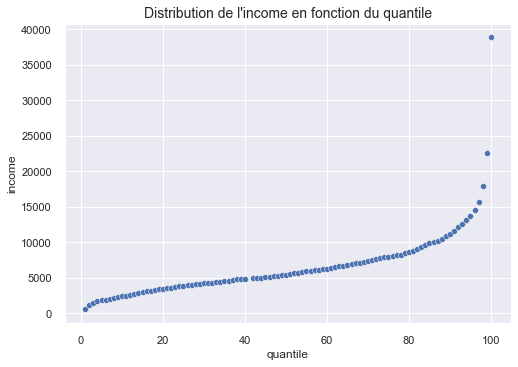

In [67]:
sns.scatterplot(data=df_lituanie, x='quantile', y='income')
plt.title("Distribution de l\'income en fonction du quantile", size=14)
plt.savefig("Distribution de l\'income en fonction du quantile.jpg")
# plt.show()

On prend les centiles entre 20 et 60

In [68]:
df_implement_quantile = df_lituanie.loc[(df_lituanie['quantile'] >= 20) & (df_lituanie['quantile'] <= 60), :]
df_implement_quantile.head(1)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country
6219,LTU,2008,20,100,3405.926,17571.0,Lithuania


In [69]:
x = df_implement_quantile['quantile'].values.reshape((-1, 1))
y = df_implement_quantile['income'].values

In [70]:
from sklearn.linear_model import LinearRegression
#instancier modèle
model_linReg = LinearRegression()
#entrainement du modèle
model_linReg.fit(x, y)

LinearRegression()

In [71]:
#précision du modèle
precision = model_linReg.score(x, y)
print('Précision du modèle : {}'.format(precision*100))

Précision du modèle : 99.29973155844326


In [72]:
#  prédiction de l'income pour le centile 41
# X = np.array([41]).reshape((-1, 1))
# model_linReg.predict(X)

In [73]:
#  prédiction de l'income pour le centile 41
quantile_concerne = 41
prediction = model_linReg.predict([[quantile_concerne]])
print('La valeur de "income" pour le centile 41 de Lituanie est : {}'.format(prediction))

La valeur de "income" pour le centile 41 de Lituanie est : [4892.11300702]


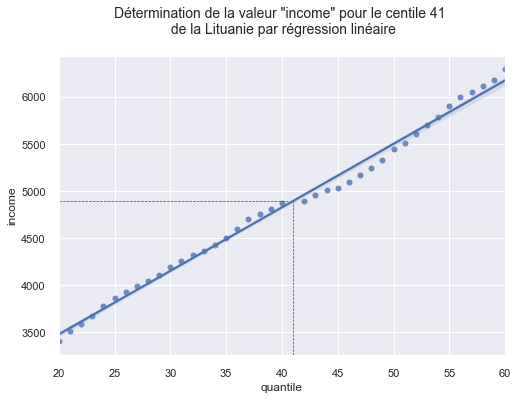

In [74]:
sns.regplot(data=df_implement_quantile, x='quantile', y='income', label=True)
plt.axhline(y = 4892.1130, color ="green", linestyle ="--", xmax =0.515, linewidth=0.7)
plt.axvline(x = 41, color ="green", linestyle ="--", ymax =0.515, linewidth=0.7)
plt.title('Détermination de la valeur "income" pour le centile 41 \n de la Lituanie par régression linéaire\n', size=14)
plt.savefig("Détermination de la valeur income pour le centile 41 de la Lituanie par régression linéaire.jpg")
plt.show()

### par interpolation

In [75]:
# Implementation par interpolation
x = df_implement_quantile['quantile'].values
y = df_implement_quantile['income'].values
f = interpolate.interp1d(x, y)
y = f(41)
y

array(4882.14065)

### par calcul de l'écart moyenne

In [76]:
# Implementation par calcul écart moyenne entre quantile 42 et 40
(df_lituanie.loc[df_lituanie['quantile'] == 42, 'income']
 .values + df_lituanie.loc[df_lituanie['quantile'] == 40, 'income'].values) / 2

array([4882.14065])

In [77]:
df_dist_revenus_code

,country_code,year,quantile,nb_quantiles,income,gdpppp,country
0,ALB,2008,1,100,728.89795,7297.00000,Albania
1,ALB,2008,2,100,916.66235,7297.00000,Albania
2,ALB,2008,3,100,1010.91600,7297.00000,Albania
3,ALB,2008,4,100,1086.90780,7297.00000,Albania
4,ALB,2008,5,100,1132.69970,7297.00000,Albania
...,...,...,...,...,...,...,...
11594,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep."
11595,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep."
11596,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep."
11597,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep."


#### Introduction des données relatives au centile 41 dans le dataframe

In [78]:
df_dist_revenus_code = df_dist_revenus_code.append({'country_code' : 'LTU' , 'year' : 2008, 'quantile' : 41,
                               'nb_quantiles' : 100, 'income' : 4882.1406, 'gdpppp': 17571.0, 'country' : 'Lithuania'} , ignore_index=True)

In [79]:
df_dist_revenus_code.describe()

,year,quantile,nb_quantiles,income,gdpppp
count,11600.000000,11600.000000,11600.0,11600.000000,1.160000e+04
mean,2007.982759,50.500000,100.0,6069.121925,4.941034e+04
std,0.909593,28.867314,0.0,9413.786596,3.966342e+05
min,2004.000000,1.000000,100.0,16.719418,3.031931e+02
25%,2008.000000,25.750000,100.0,900.768508,2.577500e+03
50%,2008.000000,50.500000,100.0,2403.492950,7.532500e+03
75%,2008.000000,75.250000,100.0,7515.313700,1.819625e+04
max,2011.000000,100.000000,100.0,176928.550000,4.300332e+06


In [80]:
df_dist_revenus_code.isnull().sum()

country_code    0
year            0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
country         0
dtype: int64

#### Il n'y a plus de valeurs manquantes

### Création d'un dataframe avec nombre d'habitants du pays ("df_revenus_pop") 
<a class="anchor" id="df_revenus_pop"></a>
### Importation et lecture des données population  
(https://data.worldbank.org/indicator/SP.POP.TOTL)
#### Les données portant essentiellemnt sur les distributions de revenus de 2008, les données concernant le nombre d'habitants portent sur cette même année.

In [81]:
cols = ['Country Code', '2008']
df_pop = pd.read_csv('WORLD_BANK_pop.csv', encoding=ENCODAGE, sep=',', skiprows=4, usecols=cols).copy()
# pop_index = pop.set_index('Country Code')
# pop_index
df_pop.head(5)

,Country Code,2008
0,ABW,101362.0
1,AFE,491173160.0
2,AFG,27722281.0
3,AFW,331772330.0
4,AGO,21695636.0


In [82]:
df_pop.columns

Index(['Country Code', '2008'], dtype='object')

### Renommage des colonnes en vue d'une future fusion

In [83]:
df_pop.columns = ['country_code', 'nb_habitants_2008']
df_pop.head(5)

,country_code,nb_habitants_2008
0,ABW,101362.0
1,AFE,491173160.0
2,AFG,27722281.0
3,AFW,331772330.0
4,AGO,21695636.0


In [84]:
df_pop.shape

(266, 2)

In [85]:
df_pop.nunique()

country_code         266
nb_habitants_2008    263
dtype: int64

#### Remarque : tous les pays n'ont pas le nombre d'habitants renseigné

In [86]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country_code       266 non-null    object 
 1   nb_habitants_2008  265 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.3+ KB


In [87]:
df_pop.describe(include='all')

,country_code,nb_habitants_2008
count,266,2.650000e+02
unique,266,NaN
top,UZB,NaN
freq,1,NaN
mean,NaN,2.721130e+08
std,NaN,8.590467e+08
min,NaN,9.880000e+03
25%,NaN,1.436670e+06
50%,NaN,9.219637e+06
75%,NaN,5.882673e+07


#### Attention : le dataset comprend la valeur de la population mondiale en 2008 ('WLD'). Ce n'est pas les données d'un pays.

In [88]:
df_pop[df_pop.country_code == 'WLD']

,country_code,nb_habitants_2008
259,WLD,6.757021e+09


In [89]:
#  recherche de valeur null => 1 pour "nb_habitants_2008"
df_pop.isnull().sum(axis=0)

country_code         0
nb_habitants_2008    1
dtype: int64

In [90]:
# Valeur null => INX
df_pop[df_pop.nb_habitants_2008.isnull()]

,country_code,nb_habitants_2008
110,INX,NaN


#### Remarque : INX n'est pas référencé dans la liste des codes alpha 3. Suppression de cette donnée

In [91]:
#  Suppression des données de "INX"
df_pop = df_pop.dropna(axis=0)

In [92]:
# Valeur null => aucune valeur null
df_pop.isnull().sum(axis=0)

country_code         0
nb_habitants_2008    0
dtype: int64

In [93]:
# Valuer dupliquée => aucune valeur dupliquée
df_pop.duplicated().sum(axis=0)

0

### Fusion des dataframes "df_dist_revenus_code" et " pop" => "df_revenus_pop"

In [94]:
# jointure droite pour récupérer toutes les données de "df_dist_revenus_code"
df_revenus_pop = pd.merge(df_pop, df_dist_revenus_code, on= 'country_code', how='right')
df_revenus_pop.head(2)

,country_code,nb_habitants_2008,year,quantile,nb_quantiles,income,gdpppp,country
0,ALB,2947314.0,2008,1,100,728.89795,7297.0,Albania
1,ALB,2947314.0,2008,2,100,916.66235,7297.0,Albania


In [95]:
df_revenus_pop.shape

(11600, 8)

In [96]:
# valeur null
df_revenus_pop.isnull().sum(axis=0)

country_code           0
nb_habitants_2008    100
year                   0
quantile               0
nb_quantiles           0
income                 0
gdpppp                 0
country                0
dtype: int64

In [97]:
df_revenus_pop[df_revenus_pop.nb_habitants_2008.isnull()].head(2)

,country_code,nb_habitants_2008,year,quantile,nb_quantiles,income,gdpppp,country
10400,TWN,NaN,2008,1,100,3477.1800,25342.0,Taïwan
10401,TWN,NaN,2008,2,100,4740.2637,25342.0,Taïwan


#### Le nombre d'habitants pour la Taïwan n'est pas indiqué dans le dataset importé. 
-  Ajout "manuel" du  nombre d'habitants de Taïwan dans le dataset "df_revenus_pop"
-  Compte tenu de la faible part des habitants de Taïwan par rapport aux habitants chinois, je décide de ne pas soustraire le nombre de Taïwannais aux chinois même s'il y a doublon.

In [98]:
df_revenus_pop['nb_habitants_2008'].fillna(23037000.0, inplace=True)

In [99]:
df_revenus_pop[df_revenus_pop['country_code'] == 'TWN'].head(2)

,country_code,nb_habitants_2008,year,quantile,nb_quantiles,income,gdpppp,country
10400,TWN,23037000.0,2008,1,100,3477.1800,25342.0,Taïwan
10401,TWN,23037000.0,2008,2,100,4740.2637,25342.0,Taïwan


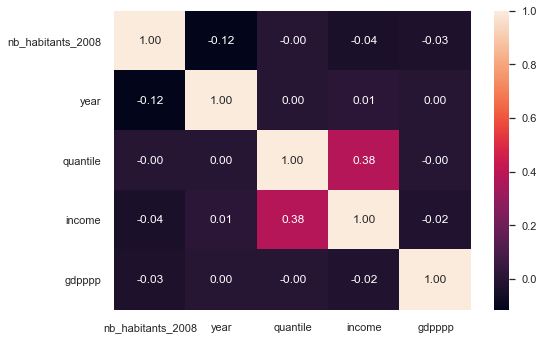

In [100]:
# Corrélation entre les différentes variables
df_revenus_popNoquant = df_revenus_pop.drop(['nb_quantiles'], axis=1)
sns.heatmap(df_revenus_popNoquant.corr(), annot=True, fmt=".2f")
plt.show()

### Pourcentage de population couverte par l'analyse (en termes de pourcentage de la population mondiale)
<a class="anchor" id="nb_hab_analyse"></a>

In [101]:
pop_totale = df_pop[df_pop.country_code == 'WLD'].nb_habitants_2008.values[0]
print('La population mondiale en 2008 s\'élève à : {} habitants '.format(pop_totale))

La population mondiale en 2008 s'élève à : 6757020825.0 habitants 


In [102]:
nb_habitants_pays = df_revenus_pop.groupby('country_code')['nb_habitants_2008'].mean()
nb_habitants_pays

country_code
ALB     2947314.0
ARG    40080159.0
ARM     2907615.0
AUT     8321496.0
AZE     8763400.0
          ...    
VEN    27635827.0
VNM    86243424.0
XKX     1747383.0
YEM    21892149.0
ZAF    49779472.0
Name: nb_habitants_2008, Length: 116, dtype: float64

In [103]:
habitant_analyse = np.sum(nb_habitants_pays)
print('Le nombre d\'habitants compris dans l\'analyse est de {}'.format(habitant_analyse))

Le nombre d'habitants compris dans l'analyse est de 6203882355.0


In [104]:
print('Le pourcentage de population couverte par l\'analyse \n(en termes de pourcentage de la population mondiale) est de {} %'.
      format(round((habitant_analyse / pop_totale) * 100), 2))

Le pourcentage de population couverte par l'analyse 
(en termes de pourcentage de la population mondiale) est de 92 %


### Les données de la World Income Distribution présentent pour chaque pays les quantiles de la distribution des revenus de leur population respective <a class="anchor" id="mission_1_questions"></a>

- de quel type de quantiles s'agit-il (quartiles, déciles, etc.) ?
- échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?


In [105]:
df_revenus_pop.loc[(df_revenus_pop['quantile'] == 50) & (df_revenus_pop['country_code']=='TWN')]                  

,country_code,nb_habitants_2008,year,quantile,nb_quantiles,income,gdpppp,country
10449,TWN,23037000.0,2008,50,100,13398.69,25342.0,Taïwan


#### Il s'agit de centile (percentile) moyen. tranche de 1% => 100 tranches => 99 séparations
- par ex TWN en 2008 : 1% de la pop la plus pauvre avait en moyenne 3477.18 dollars de revenus annuel
- C50 = médiane : le revenu médian de la pop de TWN en 2008 est de 13398.69 ou 50% de la pop de Taïwan ont plus de  13398.69 en revenu et 50% de la pop de Taïwan ont moins de 13398.69 en revenu
- rapport intercentile : C1/C99 rend compte des inégalités : 
    - plus il est élevé plus les inégalités dans un pays sont importantes 
    - plus il se rapproche de 1 et moins les inégalités dans un pays sont importantes
        - ex: rapport = 2 : les 1% les plus riches ont un revenu au moins 2 fois plus élevé que les 1% les plus pauvres
- d1 = c10, d9 = c90. c1 et c99 s’utilisent pour avoir des renseignements sur les valeurs
extrêmes de séries statistiques longues

#### Il est pertinent d'échantillonner la population en utilisant les centiles. Ainsi, on obtient des "paquets" de population de 100 plus pratique pour un dataset de grande taille.

In [106]:
df_revenus_pop.shape


(11600, 8)

### Export en csv des différents dataframes nettoyés <a class="anchor" id="export_df_csv"></a>

In [107]:
# Export du dataframe 'customers_clean' en csv
df_revenus_pop.to_csv("revenus_pays_code_pop.csv", index = False, encoding='UTF-8')

In [108]:
df_dist_revenus_code.to_csv("revenus_pays.csv", index = False, encoding='UTF-8')

### Juste pour voir ... <a class="anchor" id="juste_voir"></a>
- https://community.plotly.com/t/adding-best-fit-line-linear-regression-line-in-a-scatter-plot/6069
- https://www.it-swarm-fr.com/fr/python/afficher-lequation-de-regression-dans-le-regplot-ne-en-mer/1056619165/
- https://stackoverflow.com/questions/33336343/recover-data-from-matplotlib-scatter-plot

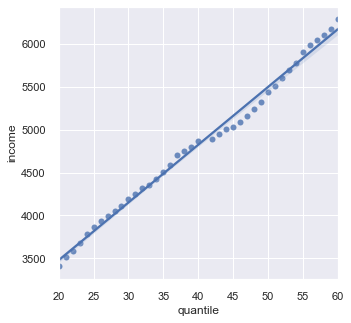

In [109]:
# https://www.it-swarm-fr.com/fr/python/afficher-lequation-de-regression-dans-le-regplot-ne-en-mer/1056619165/
# https://stackoverflow.com/questions/33336343/recover-data-from-matplotlib-scatter-plot
f =plt.figure(figsize=(5,5))
ax = f.add_subplot(1,1,1)
p = sns.regplot(data=df_implement_quantile, x='quantile', y='income', label=True,ax=ax)

In [110]:
# données de la régression linéaire
# ax1.get_lines() gives the line that is plotted and lg1.get_lines() gives the actual lines drawn in the legend box
p.get_lines()[0].get_xdata()
p.get_lines()[0].get_ydata()

array([3478.20232663, 3505.40599532, 3532.60966402, 3559.81333271,
       3587.01700141, 3614.2206701 , 3641.42433879, 3668.62800749,
       3695.83167618, 3723.03534488, 3750.23901357, 3777.44268227,
       3804.64635096, 3831.85001965, 3859.05368835, 3886.25735704,
       3913.46102574, 3940.66469443, 3967.86836313, 3995.07203182,
       4022.27570052, 4049.47936921, 4076.6830379 , 4103.8867066 ,
       4131.09037529, 4158.29404399, 4185.49771268, 4212.70138138,
       4239.90505007, 4267.10871877, 4294.31238746, 4321.51605615,
       4348.71972485, 4375.92339354, 4403.12706224, 4430.33073093,
       4457.53439963, 4484.73806832, 4511.94173701, 4539.14540571,
       4566.3490744 , 4593.5527431 , 4620.75641179, 4647.96008049,
       4675.16374918, 4702.36741788, 4729.57108657, 4756.77475526,
       4783.97842396, 4811.18209265, 4838.38576135, 4865.58943004,
       4892.79309874, 4919.99676743, 4947.20043613, 4974.40410482,
       5001.60777351, 5028.81144221, 5056.0151109 , 5083.21877

In [111]:
#  https://www.py4u.net/discuss/184199
# Récupération de tuples (x, y)
# Using p.get_children() you get a list of the individual elements of the plot
# .get_paths() : The path information of the confidence interval plot can be found with 
p.get_children()[1].get_paths()

[Path(array([[  20.        , 3513.28246861],
        [  20.        , 3450.161646  ],
        [  20.4040404 , 3477.8353221 ],
        [  20.80808081, 3505.35488856],
        [  21.21212121, 3533.07825235],
        [  21.61616162, 3560.66256413],
        [  22.02020202, 3588.1046743 ],
        [  22.42424242, 3615.77606102],
        [  22.82828283, 3642.93161499],
        [  23.23232323, 3670.00904602],
        [  23.63636364, 3697.11210521],
        [  24.04040404, 3724.85276688],
        [  24.44444444, 3752.59720387],
        [  24.84848485, 3780.34333091],
        [  25.25252525, 3808.08945794],
        [  25.65656566, 3835.75579343],
        [  26.06060606, 3863.41488252],
        [  26.46464646, 3890.91446002],
        [  26.86868687, 3918.61125647],
        [  27.27272727, 3946.22886951],
        [  27.67676768, 3973.64633891],
        [  28.08080808, 4001.12121102],
        [  28.48484848, 4028.45712098],
        [  28.88888889, 4056.19635105],
        [  29.29292929, 4083.772581

In [112]:
ax = f.get_axes()[0]
ax.collections[0].get_offsets()

masked_array(
  data=[[20.0, 3405.926],
        [21.0, 3516.2354],
        [22.0, 3588.2507],
        [23.0, 3673.9355],
        [24.0, 3781.466],
        [25.0, 3864.0429999999997],
        [26.0, 3930.2112],
        [27.0, 3990.3855],
        [28.0, 4048.922],
        [29.0, 4109.7764],
        [30.0, 4190.661],
        [31.0, 4254.907],
        [32.0, 4317.0664],
        [33.0, 4360.104],
        [34.0, 4425.0396],
        [35.0, 4503.2373],
        [36.0, 4591.1064],
        [37.0, 4701.133],
        [38.0, 4756.4336],
        [39.0, 4802.3679999999995],
        [40.0, 4868.4507],
        [42.0, 4895.8306],
        [43.0, 4950.638],
        [44.0, 5006.786],
        [45.0, 5028.5444],
        [46.0, 5088.509],
        [47.0, 5165.558],
        [48.0, 5239.3403],
        [49.0, 5327.573],
        [50.0, 5444.465],
        [51.0, 5504.883000000001],
        [52.0, 5603.514],
        [53.0, 5696.463000000001],
        [54.0, 5781.1665],
        [55.0, 5901.3584],
        [56.0, 5991.1